In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle

import matplotlib
from matplotlib import pyplot as plt
# from matplotlib import colors as mcolors
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf

# %matplotlib notebook

rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

In [2]:
def calculate_theta_phi_psi(norm, ini_psi, eval_dt=0.1, max_iter=1000, ifprint=True):
    t0 = time()
    planeShearRate = np.array((1, 0, 0))
    update_order = 3
    tcenter = np.zeros(3)
    tlateral_norm = np.random.sample(3)
    tlateral_norm = tlateral_norm / np.linalg.norm(tlateral_norm)
    tlateral_norm = tlateral_norm - norm * np.dot(norm, tlateral_norm)
    tlateral_norm = tlateral_norm / np.linalg.norm(tlateral_norm)
    helix_kwargs = {'name':         'helix',
                    'center':       tcenter,
                    'norm':         norm / np.linalg.norm(norm),
                    'lateral_norm': tlateral_norm / np.linalg.norm(tlateral_norm),
                    'speed':        0,
                    'lbd':          np.nan, 
                    'ini_psi':      ini_psi, 
                    'table_name':   'hlxB01_tau1a', }
    fileHandle = 'ShearTableProblem'
    helix_obj = jm.TableObj(**helix_kwargs)
    helix_obj.set_update_para(fix_x=False, fix_y=False, fix_z=False, update_order=update_order)
    problem = jm.ShearTableProblem(name=fileHandle, planeShearRate=planeShearRate)
    problem.add_obj(helix_obj)
    for idx in range(1, max_iter + 1):
        problem.update_location(eval_dt, print_handle='%d / %d' % (idx, max_iter))
    Table_X = np.vstack(helix_obj.center_hist)
    Table_U = np.vstack(helix_obj.U_hist)
    Table_P = np.vstack(helix_obj.norm_hist)
    Table_P2 = np.vstack(helix_obj.lateral_norm_hist)
    Table_t = np.arange(max_iter) * eval_dt + eval_dt
    Table_theta, Table_phi, Table_psi = helix_obj.theta_phi_psi
    t1 = time()
    if ifprint:
        print('run %d loops using %f' % (max_iter, (t1 - t0)))
    return Table_t, Table_theta, Table_phi, Table_psi

def calculate_angle2Y(norm, ini_psi, eval_dt=0.1, max_iter=1000, ifprint=True):
    Table_t, Table_theta, Table_phi, Table_psi = \
      calculate_theta_phi_psi(norm, ini_psi, eval_dt, max_iter, ifprint)
    last_theta = Table_theta[-1]
    last_phi = Table_phi[-1]
    last_eta = np.arccos(Table_P[-1][1])
    return last_theta, last_phi, last_eta

In [3]:
fileHandle = 'phase_map'
with open('%s.pickle' % fileHandle, 'rb') as handle:
    tpick = pickle.load(handle)
idx, last_theta, last_phi, last_eta, last_psi, \
  Table_t_list, Table_theta_list, Table_phi_list, Table_psi_list, Table_eta_list = tpick

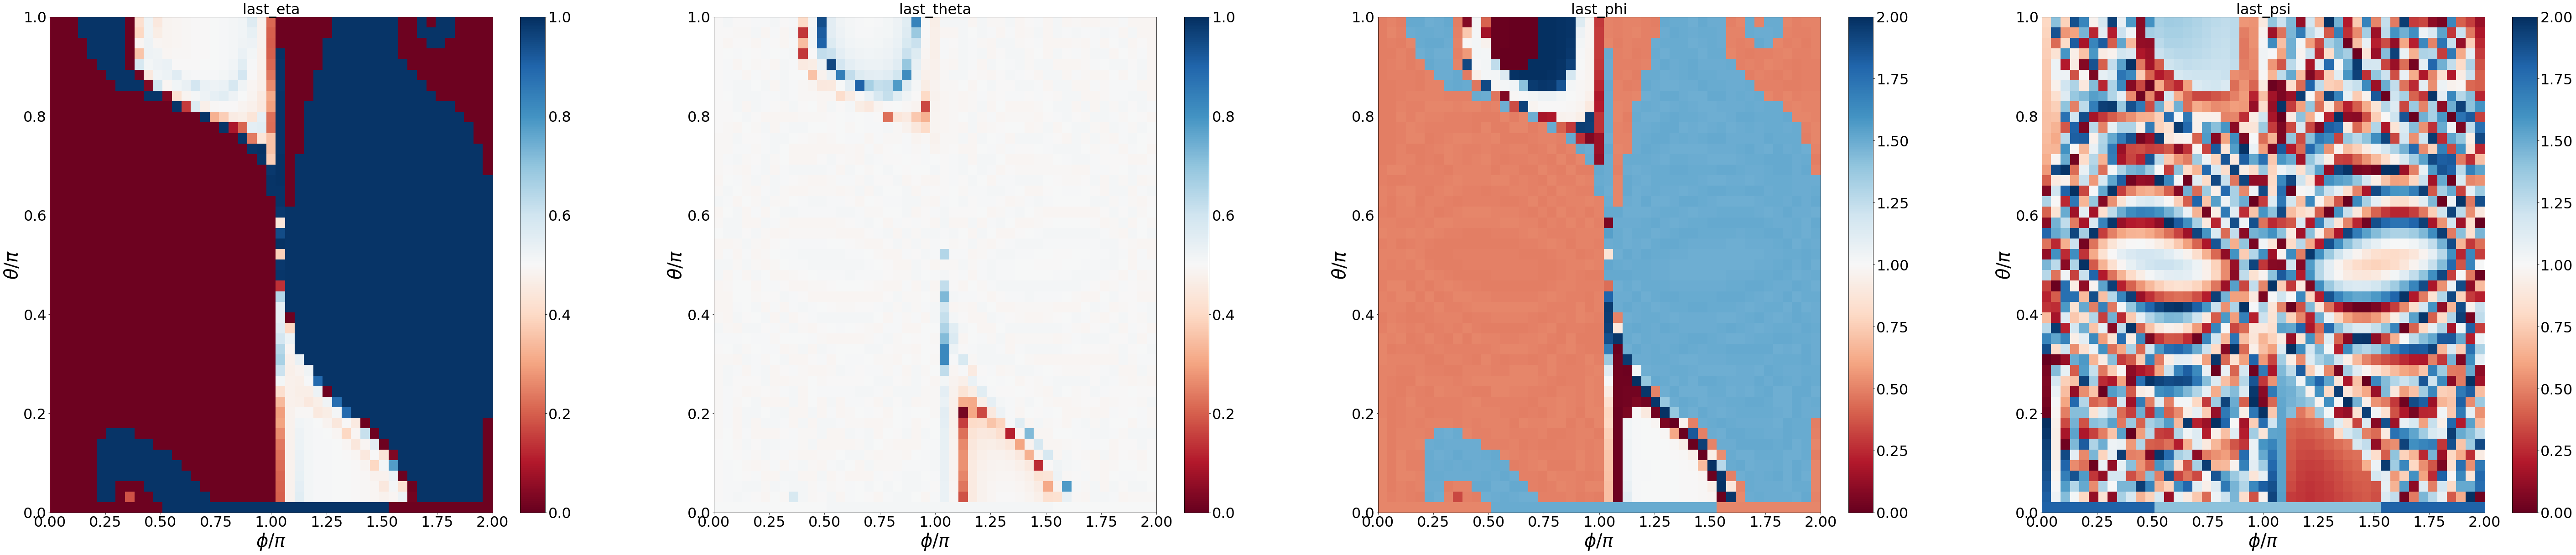

In [4]:
def tplot_fun(ax0, file_handle, t1, vmin=0, vmax=np.pi):
    tx = t1.columns.values
    ty = t1.index.values
    plt.sca(ax0)
    im = ax0.pcolor(tx / np.pi, ty / np.pi, t1.values / np.pi, 
                    cmap=cm.RdBu, vmin=vmin / np.pi, vmax=vmax / np.pi)
    fig.colorbar(im, ax=ax0).ax.tick_params(labelsize=fontsize*0.8)
    ax0.set_xlabel('$\\phi / \pi$', size=fontsize)
    ax0.set_ylabel('$\\theta / \pi$', size=fontsize)
    ax0.set_title('%s' % file_handle, size=fontsize*0.8)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
    return True

with open('phase_map.pickle', 'rb') as handle:
    tpick = pickle.load(handle)
idx, last_theta, last_phi, last_eta, last_psi, \
  Table_t_list, Table_theta_list, Table_phi_list, Table_psi_list, Table_eta_list = tpick

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(100, 20))
fig.patch.set_facecolor('white')

tplot_fun(ax0, 'last_eta', last_eta, vmin=0, vmax=np.pi)
tplot_fun(ax1, 'last_theta', last_theta, vmin=0, vmax=np.pi)
tplot_fun(ax2, 'last_phi', last_phi, vmin=0, vmax=2 * np.pi)
tplot_fun(ax3, 'last_psi', last_psi, vmin=0, vmax=2 * np.pi)
pass


In [37]:
display(idx[0.0*np.pi:0.2*np.pi].T[1*np.pi:1.4*np.pi].T)
display(last_eta[0.0*np.pi:0.2*np.pi].T[1*np.pi:1.4*np.pi].T / np.pi)
display(last_psi[0.0*np.pi:0.2*np.pi].T[1*np.pi:1.4*np.pi].T / np.pi)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
display(idx)
display(last_eta / np.pi)


ini_phi,3.2084350504746824,3.342119844244461,3.4758046380142393,3.609489431784018,3.743174225553796,3.8768590193235744,4.010543813093353,4.144228606863131,4.27791340063291
ini_theta,,,,,,,,,
0.000000,24,25,26,27,28,29,30,31,32
0.066842,72,73,74,75,76,77,78,79,80
0.133685,120,121,122,123,124,125,126,127,128
0.200527,168,169,170,171,172,173,174,175,176
0.267370,216,217,218,219,220,221,222,223,224
0.334212,264,265,266,267,268,269,270,271,272
0.401054,312,313,314,315,316,317,318,319,320
0.467897,360,361,362,363,364,365,366,367,368
0.534739,408,409,410,411,412,413,414,415,416


ini_phi,3.2084350504746824,3.342119844244461,3.4758046380142393,3.609489431784018,3.743174225553796,3.8768590193235744,4.010543813093353,4.144228606863131,4.27791340063291
ini_theta,,,,,,,,,
0.000000,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918
0.066842,0.199223,0.479312,0.557975,0.513522,0.507624,0.504664,0.502546,0.500637,0.498457
0.133685,0.203181,0.479512,0.549407,0.512934,0.507713,0.505084,0.503141,0.501179,0.498706
0.200527,0.208536,0.479625,0.542930,0.512509,0.507798,0.505403,0.503489,0.501308,0.498281
0.267370,0.215308,0.479649,0.538011,0.512170,0.507803,0.505489,0.503390,0.500736,0.496602
0.334212,0.224176,0.479559,0.533911,0.511833,0.507644,0.505162,0.502591,0.498830,0.490980
0.401054,0.237991,0.479324,0.529976,0.511387,0.507145,0.504133,0.500187,0.491726,0.445154
0.467897,0.264290,0.478897,0.525098,0.510571,0.505799,0.500801,0.489360,0.396953,0.490795
0.534739,0.299573,0.478210,0.516547,0.508079,0.500338,0.480505,0.442255,0.498186,0.454777


ini_phi,3.2084350504746824,3.342119844244461,3.4758046380142393,3.609489431784018,3.743174225553796,3.8768590193235744,4.010543813093353,4.144228606863131,4.27791340063291
ini_theta,,,,,,,,,
0.000000,1.410571,1.410571,1.410571,1.410571,1.410571,1.410571,1.410571,1.410571,1.410571
0.066842,1.920522,1.548768,0.303751,0.284924,0.269997,0.282477,0.302985,0.326043,0.349932
0.133685,1.878584,1.546585,0.336523,0.294267,0.280234,0.291894,0.312034,0.336037,0.362304
0.200527,1.831987,1.544047,0.354608,0.305549,0.292595,0.303868,0.324391,0.350217,0.379749
0.267370,1.781733,1.541248,0.368716,0.319297,0.308127,0.320184,0.342543,0.371424,0.403251
0.334212,1.727183,1.538245,0.382101,0.336351,0.328458,0.343323,0.369013,0.401930,0.430651
0.401054,1.658530,1.535061,0.396441,0.357603,0.355484,0.375401,0.406948,0.440183,0.483482
0.467897,1.523555,1.531684,0.413091,0.384151,0.391323,0.419985,0.455970,0.803766,1.171666
0.534739,1.196822,1.528056,0.433923,0.419449,0.440700,0.483343,1.343359,1.111811,0.854608


ini_phi,0.0,0.13368479376977843,0.26736958753955686,0.4010543813093353,0.5347391750791137,0.6684239688488922,0.8021087626186706,0.935793556388449,1.0694783501582275,1.203163143928006,1.3368479376977844,1.4705327314675627,1.6042175252373412,1.7379023190071197,1.871587112776898,2.0052719065466764,2.138956700316455,2.2726414940862334,2.406326287856012,2.5400110816257904,2.673695875395569,2.807380669165347,2.9410654629351254,3.074750256704904,3.2084350504746824,3.342119844244461,3.4758046380142393,3.609489431784018,3.743174225553796,3.8768590193235744,4.010543813093353,4.144228606863131,4.27791340063291,4.411598194402688,4.545282988172467,4.678967781942245,4.812652575712024,4.946337369481802,5.080022163251581,5.213706957021359,5.347391750791138,5.481076544560915,5.614761338330694,5.748446132100472,5.882130925870251,6.015815719640029,6.149500513409808,6.283185307179586
ini_theta,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0.066842,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0.133685,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143
0.200527,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191
0.267370,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239
0.334212,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287
0.401054,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335
0.467897,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383
0.534739,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431


ini_phi,0.0,0.13368479376977843,0.26736958753955686,0.4010543813093353,0.5347391750791137,0.6684239688488922,0.8021087626186706,0.935793556388449,1.0694783501582275,1.203163143928006,1.3368479376977844,1.4705327314675627,1.6042175252373412,1.7379023190071197,1.871587112776898,2.0052719065466764,2.138956700316455,2.2726414940862334,2.406326287856012,2.5400110816257904,2.673695875395569,2.807380669165347,2.9410654629351254,3.074750256704904,3.2084350504746824,3.342119844244461,3.4758046380142393,3.609489431784018,3.743174225553796,3.8768590193235744,4.010543813093353,4.144228606863131,4.27791340063291,4.411598194402688,4.545282988172467,4.678967781942245,4.812652575712024,4.946337369481802,5.080022163251581,5.213706957021359,5.347391750791138,5.481076544560915,5.614761338330694,5.748446132100472,5.882130925870251,6.015815719640029,6.149500513409808,6.283185307179586
ini_theta,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.989918,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856,0.009856
0.066842,0.009862,0.009747,0.009641,0.009768,0.009873,0.990343,0.990386,0.008949,0.180988,0.009671,0.009754,0.990145,0.990359,0.990349,0.990336,0.990212,0.990148,0.009640,0.009736,0.009646,0.009643,0.009855,0.009638,0.009827,0.199223,0.479312,0.557975,0.513522,0.507624,0.504664,0.502546,0.500637,0.498457,0.495618,0.491068,0.477417,0.490633,0.529757,0.017777,0.990332,0.990340,0.990362,0.990339,0.990358,0.990216,0.990284,0.009770,0.009862
0.133685,0.009866,0.009780,0.009672,0.009638,0.009626,0.990301,0.990363,0.009836,0.009631,0.009637,0.990219,0.990179,0.990198,0.990141,0.990221,0.990135,0.009701,0.009832,0.009681,0.009791,0.009644,0.009638,0.009727,0.009855,0.203181,0.479512,0.549407,0.512934,0.507713,0.505084,0.503141,0.501179,0.498706,0.495165,0.488488,0.445420,0.509399,0.428558,0.009878,0.990340,0.990354,0.990326,0.990360,0.990143,0.990309,0.990302,0.009828,0.009866
0.200527,0.009866,0.009806,0.009770,0.009865,0.009641,0.990361,0.990340,0.990557,0.990486,0.990363,0.990328,0.990350,0.990325,0.990171,0.990362,0.009637,0.009639,0.009794,0.009866,0.009666,0.009639,0.009642,0.009860,0.009711,0.208536,0.479625,0.542930,0.512509,0.507798,0.505403,0.503489,0.501308,0.498281,0.493359,0.479675,0.480295,0.527928,0.008075,0.990142,0.990232,0.990245,0.990360,0.990139,0.990275,0.990185,0.990180,0.009845,0.009866
0.267370,0.009862,0.009824,0.009853,0.009655,0.009650,0.990295,0.990330,0.990337,0.990340,0.990350,0.990285,0.990358,0.990244,0.990332,0.009863,0.009638,0.009639,0.009834,0.009739,0.009748,0.009824,0.009767,0.009697,0.009639,0.215308,0.479649,0.538011,0.512170,0.507803,0.505489,0.503390,0.500736,0.496602,0.487606,0.394996,0.512121,0.779556,0.990360,0.990190,0.990142,0.990296,0.990360,0.990317,0.990157,0.990134,0.990295,0.009791,0.009862
0.334212,0.009853,0.009835,0.009858,0.009697,0.009662,0.990338,0.990142,0.990343,0.990236,0.990324,0.990311,0.990327,0.990259,0.009829,0.009639,0.009639,0.009706,0.009643,0.009659,0.009680,0.009641,0.009833,0.009715,0.009652,0.224176,0.479559,0.533911,0.511833,0.507644,0.505162,0.502591,0.498830,0.490980,0.447749,0.499429,0.437226,0.034038,0.990356,0.990141,0.990191,0.990359,0.990334,0.990351,0.990143,0.990212,0.990360,0.009848,0.009853
0.401054,0.009839,0.009840,0.009774,0.009642,0.009854,0.990361,0.990324,0.990323,0.990335,0.990269,0.990362,0.009637,0.009638,0.009640,0.009649,0.009718,0.009685,0.009854,0.009746,0.009652,0.009638,0.009641,0.009730,0.009685,0.237991,0.479324,0.529976,0.511387,0.507145,0.504133,0.500187,0.491726,0.445154,0.490884,0.552819,0.009517,0.990322,0.990295,0.990214,0.990221,0.990180,0.990160,0.990361,0.990176,0.990154,0.990

In [24]:
interpolate.CubicSpline(Table_t, Table_theta).derivative(1)(Table_t)

array([ 0.77369,  0.85768,  0.86313, ...,  0.00676,  0.0074 ,  0.00802])

ini norm:  0.26736958753955686 , 0.8021087626186706 , 0
last norm:  1.59238649401 , 4.6910158423 , 3.3404432072


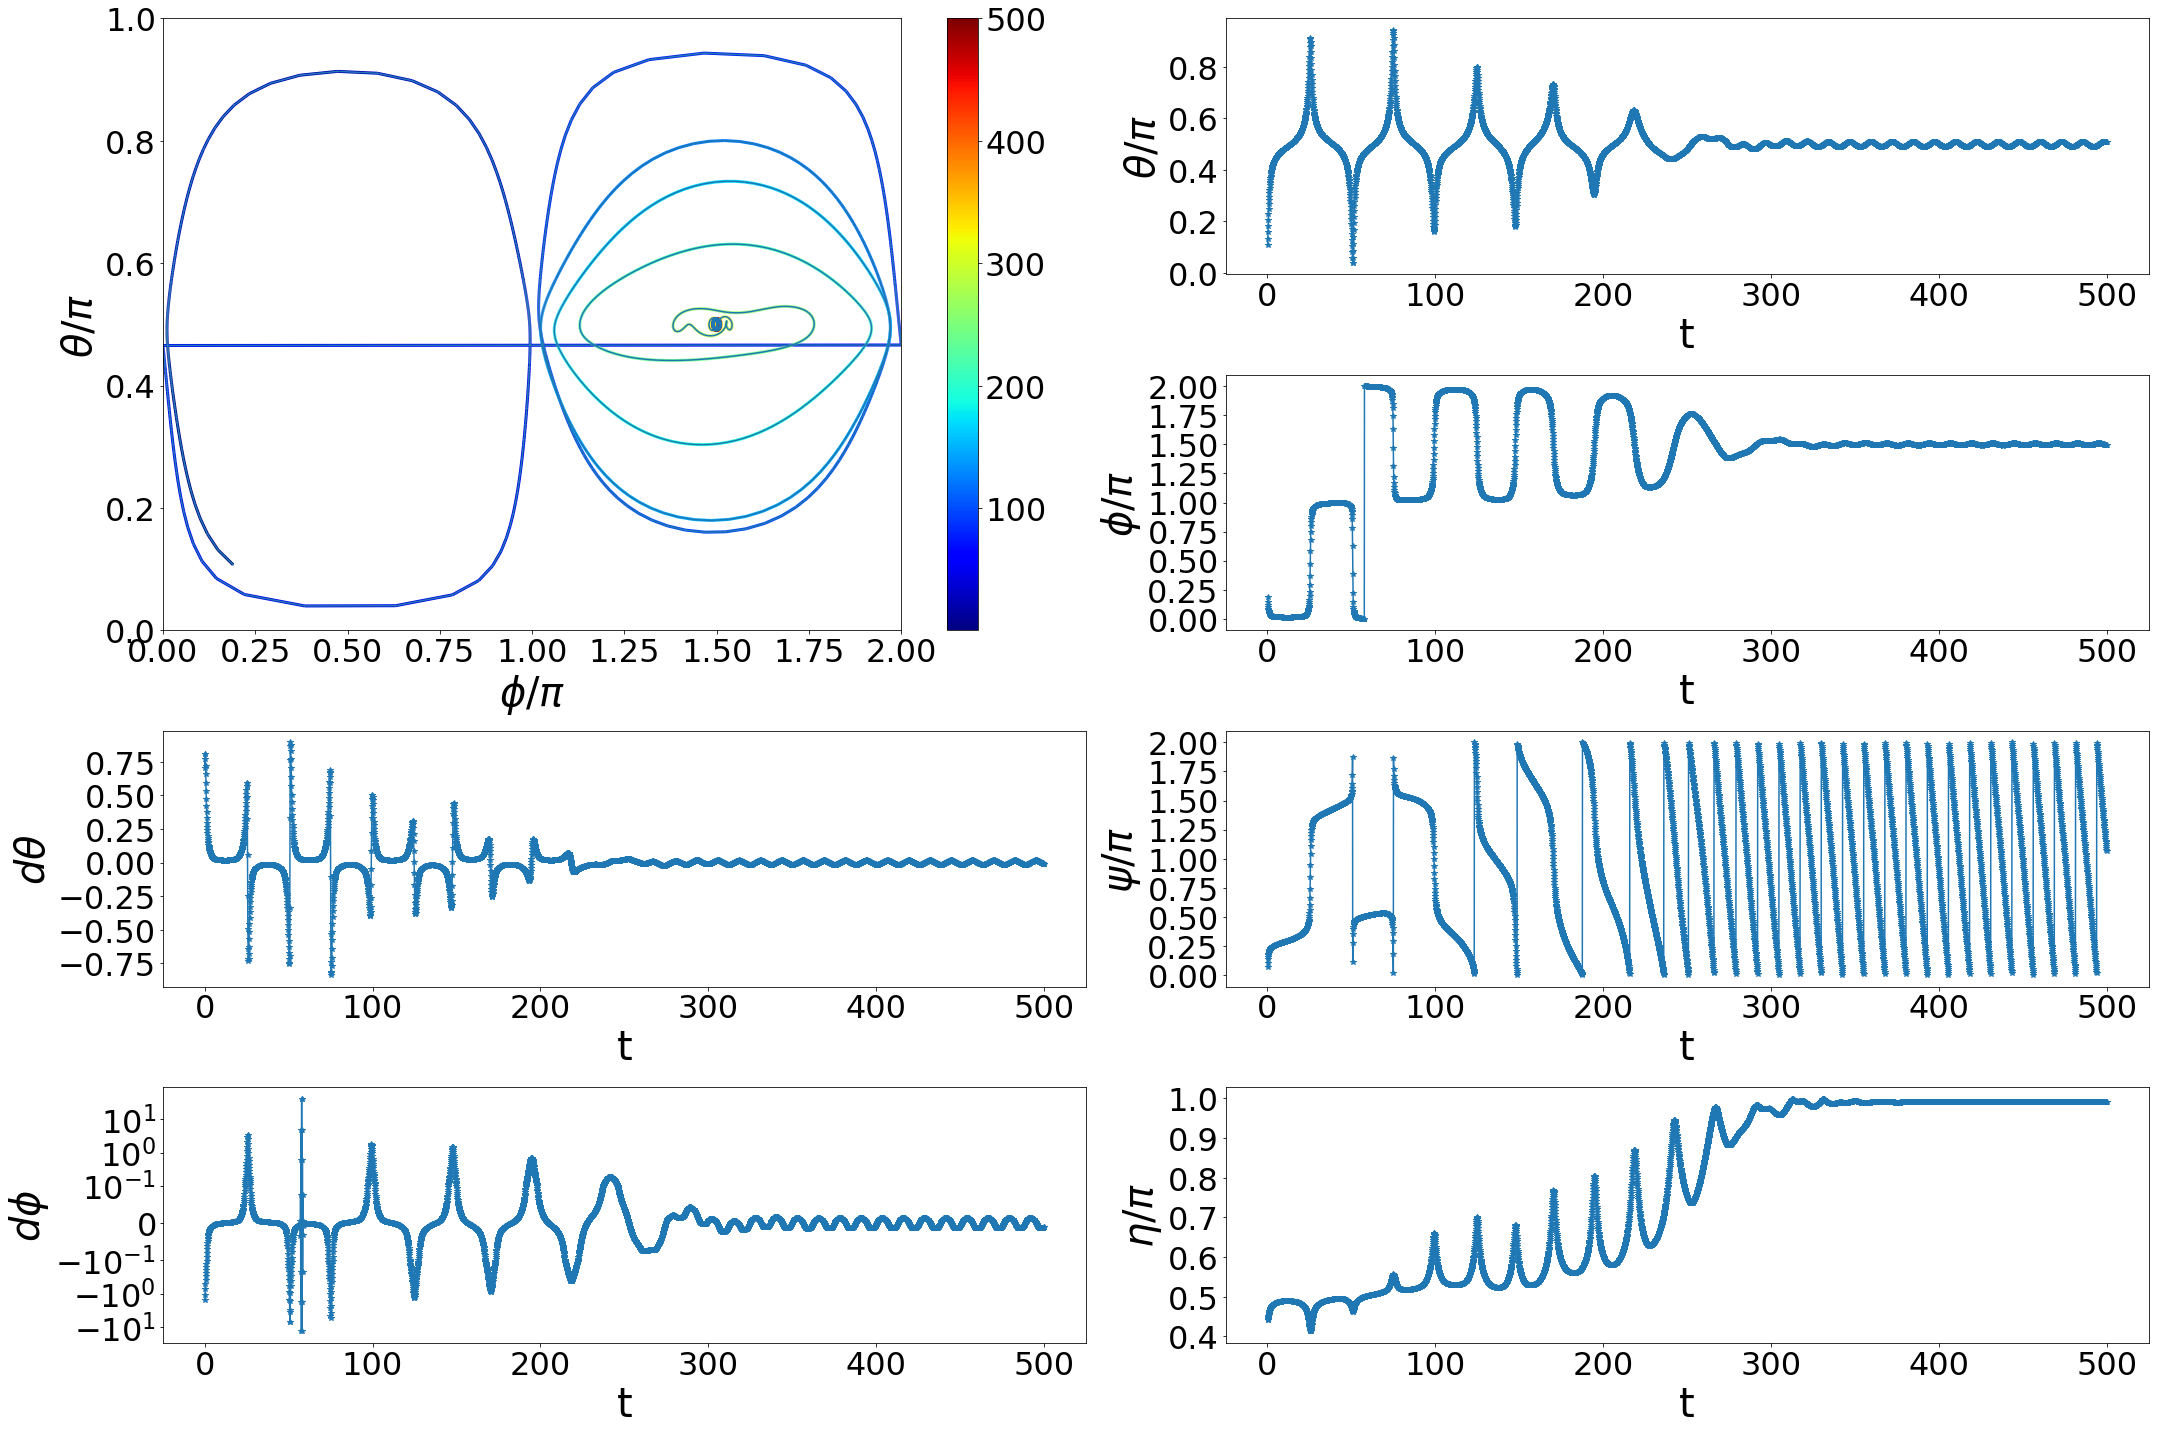

In [39]:
show_idx = 198

t1 = idx[idx==show_idx].dropna(axis=1,how='all').dropna(how='all')
ini_theta=t1.index.item()
ini_phi=t1.columns.item()
print('ini norm: ', ini_theta, ',', ini_phi, ',', 0)

Table_t = Table_t_list[show_idx]
Table_theta = Table_theta_list[show_idx]
Table_phi = Table_phi_list[show_idx]
Table_psi = Table_psi_list[show_idx]
Table_eta = Table_eta_list[show_idx]
# Table_dtheta = interpolate.CubicSpline(Table_t, Table_theta).derivative(1)(Table_t)
# Table_dphi = interpolate.CubicSpline(Table_t, Table_phi).derivative(1)(Table_t)
Table_dtheta = interpolate.UnivariateSpline(Table_t, Table_theta, k=4, s=0).derivative(1)(Table_t)
Table_dphi = interpolate.UnivariateSpline(Table_t, Table_phi, k=4, s=0).derivative(1)(Table_t)
print('last norm: ', Table_theta[-1], ',', Table_phi[-1], ',', Table_psi[-1])

fig = plt.figure(figsize=(30, 20))
fig.patch.set_facecolor('white')
ax00 = plt.subplot2grid((4, 2), (0, 0), rowspan=2)
ax01 = plt.subplot2grid((4, 2), (2, 0))
ax02 = plt.subplot2grid((4, 2), (3, 0))
ax1 = plt.subplot2grid((4, 2), (0, 1), )
ax2 = plt.subplot2grid((4, 2), (1, 1), )
ax3 = plt.subplot2grid((4, 2), (2, 1), )
ax4 = plt.subplot2grid((4, 2), (3, 1), )

# show results
norm=plt.Normalize(Table_t.min(), Table_t.max())
cmap=plt.get_cmap('jet')
plt.sca(ax00)
ax00.plot(Table_phi / np.pi, Table_theta / np.pi, '')
lc = spf.colorline(Table_phi / np.pi, Table_theta / np.pi, Table_t, 
                   ax=ax00, cmap=cmap, norm=norm, linewidth=3)
clb = fig.colorbar(lc, ax=ax00, orientation="vertical")
clb.ax.tick_params(labelsize=fontsize*0.8)
ax00.set_xlabel('$\\phi / \pi$', size=fontsize)
ax00.set_ylabel('$\\theta / \pi$', size=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
ax00.set_xlim(0, 2)
ax00.set_ylim(0, 1)

for axi, ty, axyi in zip((ax1, ax2, ax3, ax4, ax01, ax02), 
                     (Table_theta / np.pi, Table_phi / np.pi, Table_psi / np.pi, Table_eta / np.pi, 
                      Table_dtheta, Table_dphi), 
                     ('$\\theta / \pi$', '$\\phi / \pi$', '$\\psi / \pi$', '$\\eta / \pi$', 
                      '$d\\theta$', '$d\\phi$')):
    plt.sca(axi)
    axi.plot(Table_t, ty, '-*', label='Table')
    axi.set_xlabel('t', size=fontsize)
    axi.set_ylabel('%s' % axyi, size=fontsize)
#     axi.legend()
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()
ax02.set_yscale('symlog', linthreshy=0.1)

In [41]:
np.mean(np.diff(Table_t))

0.10000000000000002

In [ ]:
t_theta, t_phi, t_psi = 0.26736958753955686 , 0.8021087626186706 , 0
max_iter = 10000
eval_dt = 0.03
tnorm = np.array((np.sin(t_theta) * np.cos(t_phi), np.sin(t_theta) * np.sin(t_phi), np.cos(t_theta)))
Table_t, Table_theta, Table_phi, Table_psi = calculate_theta_phi_psi(tnorm, t_psi, eval_dt, max_iter)
Table_eta = np.arccos(np.sin(Table_theta) * np.sin(Table_phi))
print('last norm: ', Table_theta[-1], ',', Table_phi[-1], ',', Table_psi[-1])

# show table results. 
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('white')
ax0 = plt.subplot2grid((4, 2), (0, 0), rowspan=4)
ax1 = plt.subplot2grid((4, 2), (0, 1), )
ax2 = plt.subplot2grid((4, 2), (1, 1), )
ax3 = plt.subplot2grid((4, 2), (2, 1), )
ax4 = plt.subplot2grid((4, 2), (3, 1), )
norm=plt.Normalize(Table_t.min(), Table_t.max())
cmap=plt.get_cmap('jet')
ax0.plot(Table_phi / np.pi, Table_theta / np.pi, ' ')
lc = spf.colorline(Table_phi / np.pi, Table_theta / np.pi, Table_t, 
                   ax=ax0, cmap=cmap, norm=norm, linewidth=3)
clb = fig.colorbar(lc, ax=ax0, orientation="vertical")
ax0.set_xlabel('$\\phi / \pi$', size=fontsize)
ax0.set_ylabel('$\\theta / \pi$', size=fontsize)
plt.sca(ax0)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)
ax1.plot(Table_t, Table_theta / np.pi, '-*', label='Table')
ax2.plot(Table_t, Table_phi / np.pi, '-*', label='Table')
ax3.plot(Table_t, Table_psi / np.pi, '-*', label='Table')
ax4.plot(Table_t, Table_eta / np.pi, '-*', label='Table')
for axi, axyi in zip((ax1, ax2, ax3, ax4), 
                     ('$\\theta / \pi$', '$\\phi / \pi$', '$\\psi / \pi$', '$\\eta / \pi$')):
    plt.sca(axi)
    plt.sca(axi)
    axi.set_xlabel('t', size=fontsize)
    axi.set_ylabel('%s' % axyi, size=fontsize)
#     axi.legend()
    plt.xticks(fontsize=fontsize*0.5)
    plt.yticks(fontsize=fontsize*0.5)
plt.tight_layout()


In [ ]:
Table_psi / np.pi